# Selecting Praesepe members, compiling data and fitting a gyrochronology relation

This notebook reproduces figures in the paper.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
from astropy.io import fits

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Douglas Praesepe rotation period catalog.

In [3]:
douglas = pd.read_csv("../../data/praesepe_douglas.csv", skiprows=89)
douglas.head()

,Name,EPIC,Mass,r'mag,Kmag,Prot1,Pw1,Q1,Clean?,Sig,...,SmAmp,P,Kpmag,PrCat,PCat,All,2M,Simbad,_RA,_DE
0,KW547,211898181,1.05,11.65,9.70,,,2,,,...,,,11.68,0,0,All,2M,Simbad,130.157851,18.700121
1,A 448,211845572,0.15,18.59,14.57,,,2,,,...,,,17.36,0,0,All,2M,Simbad,129.143078,17.957611
2,KW548,212004731,0.80,11.81,10.59,3.96,0.1085,0,N,0.00838,...,0.02363,2,11.79,0,0,All,2M,Simbad,130.815494,20.333748
3,JC201,211930461,0.73,13.49,10.76,14.59,0.8391,0,Y,0.00816,...,0.38429,2,13.49,0,1,All,2M,Simbad,130.088905,19.181773
4,,212094548,0.16,19.52,14.25,6.60,0.0089,1,N,0.00521,...,0.77485,2,18.71,0,1,All,2M,Simbad,130.281121,21.915739


Format the data: convert periods from strings to floats and get rid of spaces in the dataframe

In [4]:
periods = []
for p in douglas.Prot1.values:
    if p == "     ":
        periods.append(0.)
    else:
        periods.append(float(p))
douglas["period"] = np.array(periods)

Load the Bedell Gaia-K2 crossmatch (downloaded from gaia-kepler.fun) and ensmallen it so it's a managable size.

In [18]:
with fits.open('../../data/k2_dr2_1arcsec.fits') as data:
    bedell = pd.DataFrame(data[1].data)
bedell.keys()

c5_mask = bedell.k2_campaign_str.values == "5"
c5 = pd.DataFrame(dict({"source_id": bedell.source_id.values[c5_mask], 
                        "EPIC": bedell.epic_number.values[c5_mask], 
                        "ra": bedell.ra.values[c5_mask], 
                        "dec": bedell.dec.values[c5_mask], 
                        "G": bedell.phot_g_mean_mag.values[c5_mask],
                        "bp": bedell.phot_bp_mean_mag.values[c5_mask],
                        "rp": bedell.phot_rp_mean_mag.values[c5_mask],
                        "parallax": bedell.parallax.values[c5_mask],
                        "parallax_err": bedell.parallax_error.values[c5_mask],
                       }))

Text(0,0.5,'Dec')

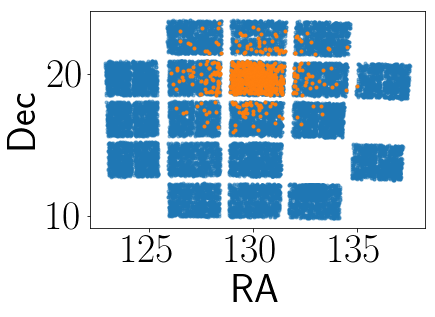

In [25]:
plt.plot(c5.ra, c5.dec, ".", alpha=.5)
plt.plot(douglas._RA, douglas._DE, ".")
plt.xlabel("RA")
plt.ylabel("Dec")

Just plot the crossmatched stars.

In [23]:
df = pd.merge(c5, douglas, on="EPIC", how="inner")
df.drop_duplicates("EPIC", inplace=True)
print(np.shape(c5), np.shape(douglas), np.shape(df))

(27500, 9) (794, 29) (757, 37)


Text(0,0.5,'Dec')

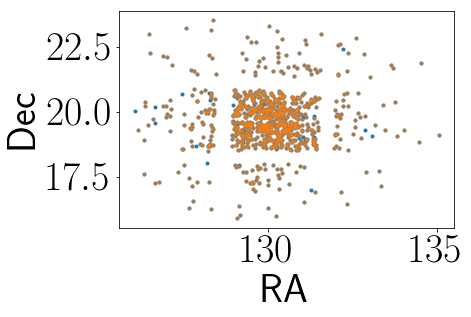

In [26]:
plt.plot(douglas._RA, douglas._DE, ".")
plt.plot(df.ra, df.dec, ".", alpha=.5)
plt.xlabel("RA")
plt.ylabel("Dec")

In [28]:
df.keys()

Index(['EPIC', 'G', 'bp', 'dec', 'parallax', 'parallax_err', 'ra', 'rp',
       'source_id', 'Name', 'Mass', 'r'mag', 'Kmag', 'Prot1', 'Pw1', 'Q1',
       'Clean?', 'Sig', 'Prot2', 'Pw2', 'Q2', 'MP?', 'SE?', 'Bl?', 'Bin?',
       'RawAmp', 'SmAmp', 'P', 'Kpmag', 'PrCat', 'PCat', 'All', '2M', 'Simbad',
       '_RA', '_DE', 'period'],
      dtype='object')

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


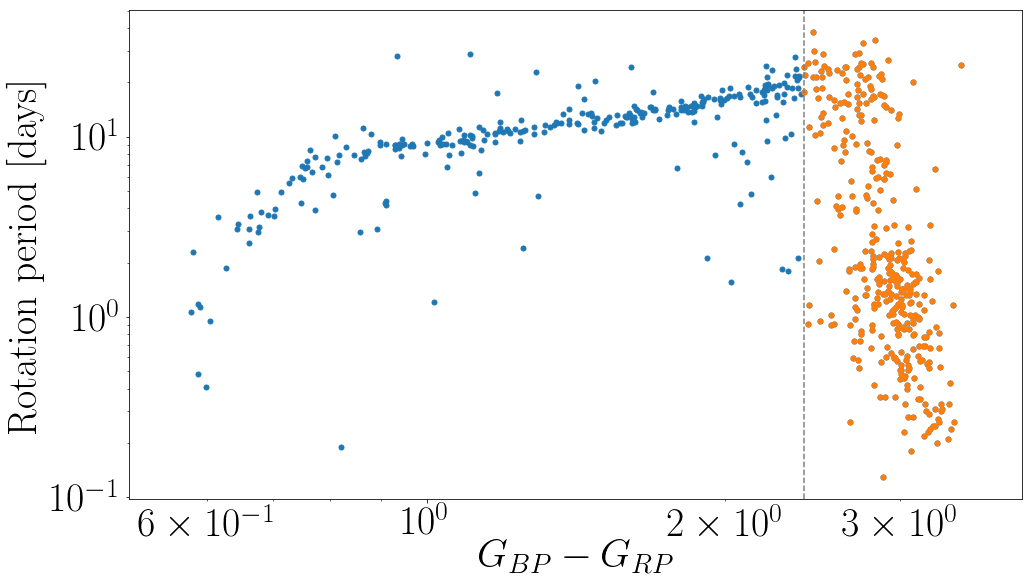

In [36]:
plt.figure(figsize=(16, 9))

gaia_color = df.bp - df.rp
Mdwarf_cut = 2.4
color_mask = gaia_color < Mdwarf_cut

plt.loglog(gaia_color, df.period, ".", ms=10)
plt.loglog(gaia_color[~color_mask], df.period[~color_mask], ".", color="tab:orange", ms=10)
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.xlim(10**-.3, 10**.6)
plt.axvline(Mdwarf_cut, color=".5", ls="--")
plt.savefig("../praesepe.pdf")